In [67]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import permutations

from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster

In [68]:
# load data
with open("us_state_capitals_with_coordinates.json", "r") as f:
    data = json.load(f)
df = pd.DataFrame(data)

start = "Iowa"
end = "Washington D.C."

In [69]:
geolocator = Nominatim(user_agent="geoapi")
location = geolocator.geocode(f"{end}, USA")
latitude = location.latitude
longitude = location.longitude

In [70]:
new_row = pd.DataFrame({
    "state": [end],
    "capital": [end],
    "latitude": [latitude],
    "longitude": [longitude],
})

In [71]:
df = pd.concat([df, new_row], ignore_index=True)

### Functions

#### distance and centeroid

In [72]:
def haversine(lat1, lon1, lat2, lon2):
    '''
    calculate the great-circle distance between two points on the Earth
    specified in decimal degrees using the Haversine formula.
    '''
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = phi2 - phi1
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(delta_lambda/2)**2
    return R * (2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))

In [73]:
def geographic_centroid_df(df: pd.DataFrame, lat_col: str = "latitude", lon_col: str = "longitude") -> list:
    """
    Compute the geographic centroid (spherical method) from a DataFrame.

    Parameters:
        df: pandas DataFrame containing latitude and longitude columns
        lat_col: name of the latitude column (default: "lat")
        lon_col: name of the longitude column (default: "lon")

    Returns:
        A list [latitude, longitude] in degrees representing the centroid
    """
    if df.empty:
        raise ValueError("The DataFrame is empty. Cannot compute centroid.")

    x = y = z = 0.0

    # Convert each (lat, lon) to Cartesian coordinates and accumulate
    for _, row in df.iterrows():
        lat = math.radians(row[lat_col])
        lon = math.radians(row[lon_col])
        x += math.cos(lat) * math.cos(lon)
        y += math.cos(lat) * math.sin(lon)
        z += math.sin(lat)

    # Average the x, y, z components
    total = len(df)
    x /= total
    y /= total
    z /= total

    # Convert the average Cartesian coordinates back to latitude and longitude
    lon_center = math.atan2(y, x)
    hyp = math.sqrt(x * x + y * y)
    lat_center = math.atan2(z, hyp)

    return [math.degrees(lat_center), math.degrees(lon_center)]

#### Nearest neighbor

In [74]:
def route_distance(route, coords):
    return sum(haversine(*coords[route[i]], *coords[route[i+1]]) for i in range(len(route)-1))

In [75]:
def nearest_neighbor_path(df, start, end, lat_col = "latitude", lon_col = "longitude"):
    n = len(df)
    unvisited = set(range(n))
    unvisited.remove(start)
    if end in unvisited:
        unvisited.remove(end)

    route = [start]
    current = start
    while unvisited:
        next_city = min(unvisited, key=lambda i: haversine(
            df.iloc[current][lat_col], df.iloc[current][lon_col],
            df.iloc[i][lat_col], df.iloc[i][lon_col]
        ))
        route.append(next_city)
        unvisited.remove(next_city)
        current = next_city

    route.append(end)
    return route

#### optimization

In [76]:
def two_opt_path(route, coords):
    best = route[:]
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 3):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if route_distance(new_route, coords) < route_distance(best, coords):
                    best = new_route
                    improved = True
    return best

In [77]:
def three_opt_path(route, coords):
    """
    Perform 3-opt optimization to improve a given TSP route.

    Parameters:
        route: list of city indices (e.g., [0, 5, 2, ...])
        coords: list of (lat, lon) tuples, indexed the same as route

    Returns:
        Optimized route (list of indices)
    """
    def route_distance(route, coords):
        return sum(haversine(*coords[route[i]], *coords[route[i+1]]) for i in range(len(route)-1))

    best = route[:]
    improved = True

    while improved:
        improved = False
        n = len(best)

        for i in range(1, n - 4):
            for j in range(i + 1, n - 3):
                for k in range(j + 1, n - 1):
                    A = best[:i]
                    B = best[i:j]
                    C = best[j:k]
                    D = best[k:]

                    # 7 different reconnections (including original and 2-opt variants)
                    candidates = [
                        A + B + C + D,
                        A + B[::-1] + C + D,
                        A + B + C[::-1] + D,
                        A + B[::-1] + C[::-1] + D,
                        A + C + B + D,
                        A + C[::-1] + B[::-1] + D,
                        A + C + B[::-1] + D,
                    ]

                    for candidate in candidates:
                        if route_distance(candidate, coords) < route_distance(best, coords):
                            best = candidate
                            improved = True
                            break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break

    return best


#### Brute force

In [78]:
def path_distance(route, df, lat_col = "latitude", lon_col = "longitude"):
    """Compute the total distance of a given route"""
    total = 0
    for i in range(len(route) - 1):
        lat1, lon1 = df.loc[route[i], [lat_col, lon_col]]
        lat2, lon2 = df.loc[route[i+1], [lat_col, lon_col]]
        total += haversine(lat1, lon1, lat2, lon2)
    return total


In [79]:
def solve_tsp_brute_force(df, start_index, end_index, lat_col="latitude", lon_col="longitude"):
    """
    Brute-force solution for open-path TSP with fixed start and end.

    Parameters:
        df: DataFrame with coordinates
        start_index: starting point index
        end_index: ending point index
        lat_col, lon_col: names of lat/lon columns

    Returns:
        (shortest_path_indices, total_distance)
    """
    n = len(df)
    indices = list(range(n))
    
    # exclude start and end from permutations
    middle_nodes = [i for i in indices if i not in (start_index, end_index)]
    
    best_route = None
    min_dist = float('inf')

    for perm in permutations(middle_nodes):
        route = [start_index] + list(perm) + [end_index]
        dist = path_distance(route, df, lat_col, lon_col)
        if dist < min_dist:
            best_route = route
            min_dist = dist

    return best_route, min_dist

### Step 1: Cluster

In [80]:
# cluster
k = 10
kmeans = KMeans(n_clusters=k, random_state=42).fit(df[["latitude", "longitude"]])
df["cluster"] = kmeans.labels_

In [81]:
for i in range(k):
    group = df[df["cluster"] == i]
    print(f"\nCluster {i + 1} ({len(group)} cities):")
    for _, row in group.iterrows():
        print(f" - {row['capital']}, {row['state']}")


Cluster 1 (7 cities):
 - Dover, Delaware
 - Annapolis, Maryland
 - Trenton, New Jersey
 - Raleigh, North Carolina
 - Harrisburg, Pennsylvania
 - Richmond, Virginia
 - Washington D.C., Washington D.C.

Cluster 2 (3 cities):
 - Boise, Idaho
 - Helena, Montana
 - Salt Lake City, Utah

Cluster 3 (5 cities):
 - Little Rock, Arkansas
 - Baton Rouge, Louisiana
 - Jackson, Mississippi
 - Oklahoma City, Oklahoma
 - Austin, Texas

Cluster 4 (1 cities):
 - Juneau, Alaska

Cluster 5 (1 cities):
 - Honolulu, Hawaii

Cluster 6 (8 cities):
 - Des Moines, Iowa
 - Topeka, Kansas
 - Saint Paul, Minnesota
 - Jefferson City, Missouri
 - Lincoln, Nebraska
 - Bismarck, North Dakota
 - Pierre, South Dakota
 - Madison, Wisconsin

Cluster 7 (4 cities):
 - Sacramento, California
 - Carson City, Nevada
 - Salem, Oregon
 - Olympia, Washington

Cluster 8 (11 cities):
 - Montgomery, Alabama
 - Tallahassee, Florida
 - Atlanta, Georgia
 - Springfield, Illinois
 - Indianapolis, Indiana
 - Frankfort, Kentucky
 - Lansi

C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_21088\3654726013.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k)


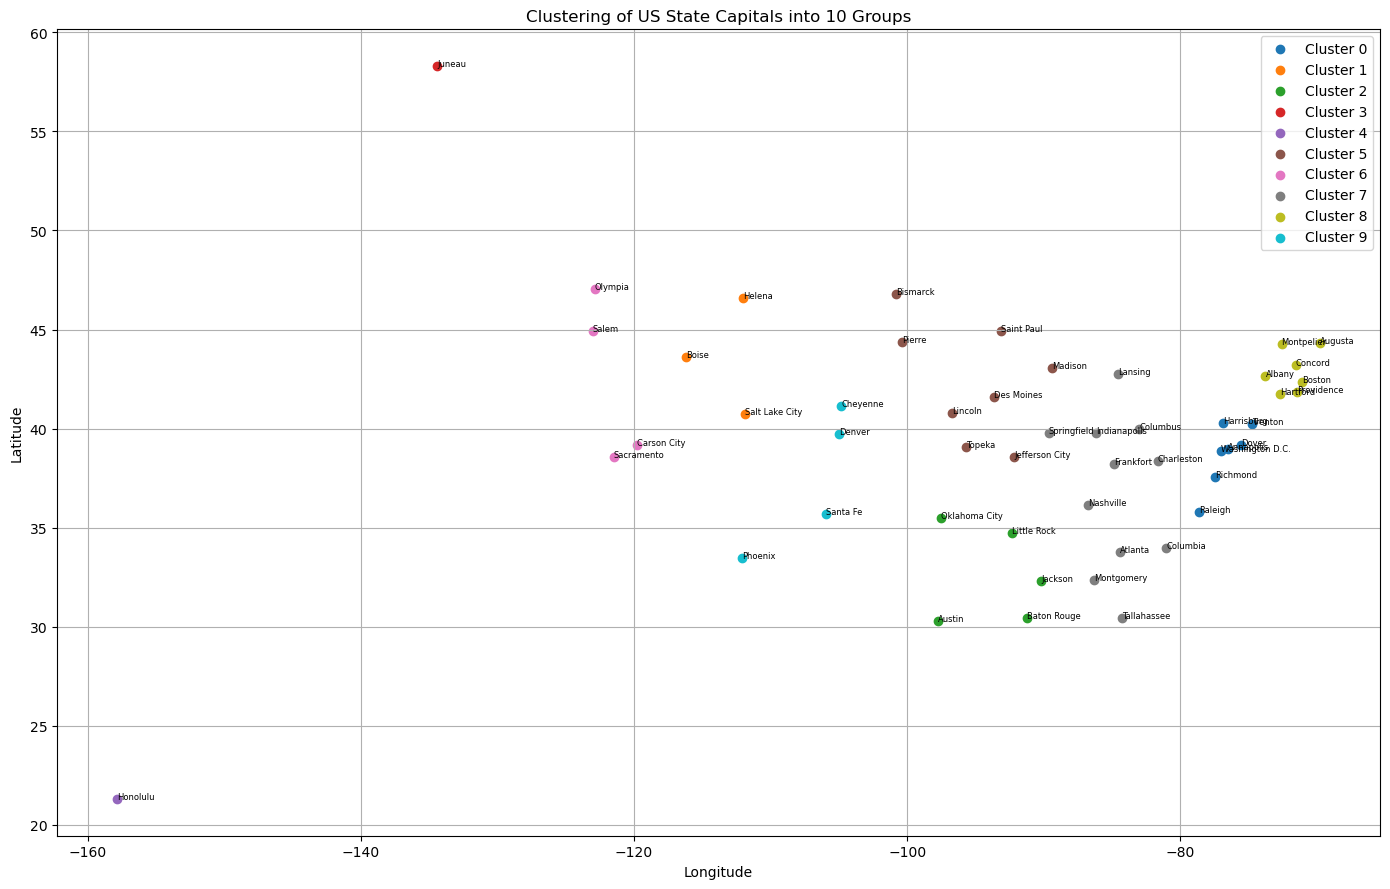

In [82]:
colors = plt.cm.get_cmap('tab10', k)
plt.figure(figsize=(14, 9))

for i in range(k):
    group = df[df["cluster"] == i]
    plt.scatter(group["longitude"], group["latitude"], color=colors(i), label=f"Cluster {i}")
    for _, row in group.iterrows():
        plt.text(row["longitude"], row["latitude"], row["capital"], fontsize=6)

plt.title(f"Clustering of US State Capitals into {k} Groups")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("us_capitals_clusters.png", dpi=300)  
plt.show()


### Step 2: locate center of each cluster

In [83]:
df_cluster = df.groupby("cluster").apply(geographic_centroid_df).reset_index(name="centroid")
df_cluster['latitude'] = df_cluster['centroid'].apply(lambda x: x[0])
df_cluster['longitude'] = df_cluster['centroid'].apply(lambda x: x[1])

C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_21088\385270901.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cluster = df.groupby("cluster").apply(geographic_centroid_df).reset_index(name="centroid")


In [84]:
df_cluster

,cluster,centroid,latitude,longitude
0,0,"[38.697076579409895, -76.70180241299124]",38.697077,-76.701802
1,1,"[43.673778349643, -113.37410143500972]",43.673778,-113.374101
2,2,"[32.688922198158416, -93.771498598484]",32.688922,-93.771499
3,3,"[58.30194959999999, -134.419734]",58.301950,-134.419734
4,4,"[21.304547, -157.855676]",21.304547,-157.855676
5,5,"[42.46109366390208, -95.15403728153507]",42.461094,-95.154037
6,6,"[42.440242031706774, -121.73338288823389]",42.440242,-121.733383
7,7,"[36.890998143664426, -84.7701520354907]",36.890998,-84.770152
8,8,"[42.91757413692964, -71.83533444544146]",42.917574,-71.835334
9,9,"[37.54269397886172, -107.05551503481792]",37.542694,-107.055515


C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_21088\90646862.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k)


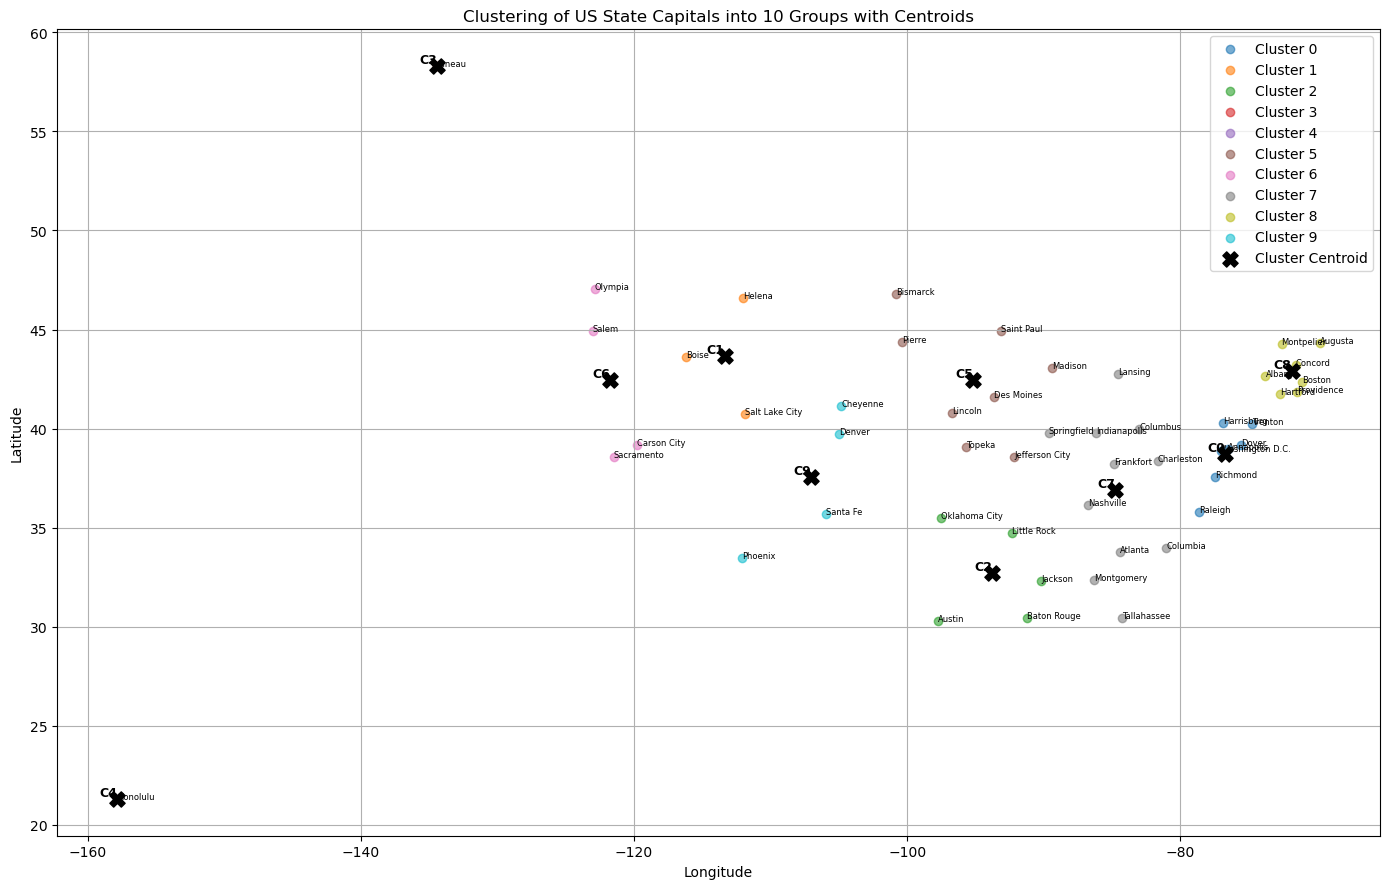

In [85]:
import matplotlib.pyplot as plt

colors = plt.cm.get_cmap('tab10', k)
plt.figure(figsize=(14, 9))

for i in range(k):
    group = df[df["cluster"] == i]
    plt.scatter(group["longitude"], group["latitude"], color=colors(i), label=f"Cluster {i}", alpha=0.6)
    for _, row in group.iterrows():
        plt.text(row["longitude"], row["latitude"], row["capital"], fontsize=6)

plt.scatter(df_cluster["longitude"], df_cluster["latitude"], 
            color='black', marker='X', s=120, label="Cluster Centroid")

for _, row in df_cluster.iterrows():
    plt.text(row["longitude"], row["latitude"], f"C{int(row['cluster'])}", 
             fontsize=9, color='black', fontweight='bold', ha='right', va='bottom')

plt.title(f"Clustering of US State Capitals into {k} Groups with Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 3: order for cluster

In [86]:
# Here we find the clusters for the start and end states
start_cluster = df.query("capital == @start or state == @start")['cluster'].values[0]
end_cluster = df.query("capital == @end or state == @end")['cluster'].values[0]
print(f"Start cluster: {start_cluster}, End cluster: {end_cluster}")

Start cluster: 5, End cluster: 0


In [87]:
# Use the centroid in df_cluster to represent each cluster
# Compute the shortest path between cluster centroids using brute force
cluster_order, total_dist = solve_tsp_brute_force(
    df=df_cluster,
    start_index=start_cluster,
    end_index=end_cluster,
    lat_col="latitude",
    lon_col="longitude"
)

print("Shortest path indices:", cluster_order)
print("Visit order:", [f"Cluster {i}" for i in cluster_order])
print(f"Total path distance: {total_dist:.2f} km")

Shortest path indices: [5, 3, 4, 6, 1, 9, 2, 7, 8, 0]
Visit order: ['Cluster 5', 'Cluster 3', 'Cluster 4', 'Cluster 6', 'Cluster 1', 'Cluster 9', 'Cluster 2', 'Cluster 7', 'Cluster 8', 'Cluster 0']
Total path distance: 17579.82 km


### Step 4: connection from 1 cluster to another

In [88]:
# Initialize "start" and "end" columns
df_cluster["start"] = np.nan
df_cluster["end"] = np.nan

# Manually set the known start cities
df_cluster.loc[start_cluster, "start"] = df.query("capital == @start or state == @start")['capital'].values[0]

# Iterate through the clusters in the cluster order
# and find the best start and end cities for each pair of adjacent clusters
for i in range(1, len(cluster_order)):
    prev_cluster = cluster_order[i - 1]
    curr_cluster = cluster_order[i]

    print(f"Processing clusters: {prev_cluster} -> {curr_cluster}")

    prev_cities = df[df["cluster"] == prev_cluster]
    curr_cities = df[df["cluster"] == curr_cluster]

    min_dist = float("inf")
    best_prev_city = None
    best_curr_city = None

    for _, city1 in prev_cities.iterrows():
        for _, city2 in curr_cities.iterrows():
            d = haversine(city1["latitude"], city1["longitude"], city2["latitude"], city2["longitude"])
            if d < min_dist:
                min_dist = d
                best_prev_city = city1["capital"]
                best_curr_city = city2["capital"]

    print(f"Best cities: {best_prev_city} (Cluster {prev_cluster}) -> {best_curr_city} (Cluster {curr_cluster}) with distance {min_dist:.2f} km")

    df_cluster.loc[prev_cluster, "end"] = best_prev_city
    df_cluster.loc[curr_cluster, "start"] = best_curr_city

# Manually set the known end cities
df_cluster.loc[end_cluster, "end"] = df.query("capital == @end or state == @end")['capital'].values[0]

Processing clusters: 5 -> 3
Best cities: Bismarck (Cluster 5) -> Juneau (Cluster 3) with distance 2570.02 km
Processing clusters: 3 -> 4
Best cities: Juneau (Cluster 3) -> Honolulu (Cluster 4) with distance 4524.22 km
Processing clusters: 4 -> 6
Best cities: Honolulu (Cluster 4) -> Sacramento (Cluster 6) with distance 3958.83 km
Processing clusters: 6 -> 1
Best cities: Salem (Cluster 6) -> Boise (Cluster 1) with distance 563.26 km
Processing clusters: 1 -> 9
Best cities: Salt Lake City (Cluster 1) -> Cheyenne (Cluster 9) with distance 594.82 km
Processing clusters: 9 -> 2
Best cities: Santa Fe (Cluster 9) -> Oklahoma City (Cluster 2) with distance 761.73 km
Processing clusters: 2 -> 7
Best cities: Jackson (Cluster 2) -> Montgomery (Cluster 7) with distance 364.03 km
Processing clusters: 7 -> 8
Best cities: Charleston (Cluster 7) -> Albany (Cluster 8) with distance 819.42 km
Processing clusters: 8 -> 0
Best cities: Hartford (Cluster 8) -> Trenton (Cluster 0) with distance 244.56 km


C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_21088\2424610385.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Des Moines' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[start_cluster, "start"] = df.query("capital == @start or state == @start")['capital'].values[0]
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_21088\2424610385.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Bismarck' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cluster.loc[prev_cluster, "end"] = best_prev_city


In [89]:
df_cluster

,cluster,centroid,latitude,longitude,start,end
0,0,"[38.697076579409895, -76.70180241299124]",38.697077,-76.701802,Trenton,Washington D.C.
1,1,"[43.673778349643, -113.37410143500972]",43.673778,-113.374101,Boise,Salt Lake City
2,2,"[32.688922198158416, -93.771498598484]",32.688922,-93.771499,Oklahoma City,Jackson
3,3,"[58.30194959999999, -134.419734]",58.301950,-134.419734,Juneau,Juneau
4,4,"[21.304547, -157.855676]",21.304547,-157.855676,Honolulu,Honolulu
5,5,"[42.46109366390208, -95.15403728153507]",42.461094,-95.154037,Des Moines,Bismarck
6,6,"[42.440242031706774, -121.73338288823389]",42.440242,-121.733383,Sacramento,Salem
7,7,"[36.890998143664426, -84.7701520354907]",36.890998,-84.770152,Montgomery,Charleston
8,8,"[42.91757413692964, -71.83533444544146]",42.917574,-71.835334,Albany,Hartford
9,9,"[37.54269397886172, -107.05551503481792]",37.542694,-107.055515,Cheyenne,Santa Fe


### Step 5: order inside each cluster

In [90]:
# Dictionary to store results
cluster_paths = {}

# Loop over each cluster
for idx, row in df_cluster.iterrows():
    c = row["cluster"]
    start_city = row["start"]
    end_city = row["end"]

    # Skip if start or end is missing
    if pd.isna(start_city) or pd.isna(end_city):
        continue

    # Extract all cities in the current cluster
    cities = df[df["cluster"] == c].reset_index()

    # Get the index of the start and end cities
    start_idx = cities[cities["capital"] == start_city].index[0]
    end_idx = cities[cities["capital"] == end_city].index[0]

    # parameters
    n_cities = len(cities)
    lat_col = "latitude"
    lon_col = "longitude"

    if n_cities <= 8:
        # Use brute-force TSP solver
        route = solve_tsp_brute_force(
            df=cities,
            start_index=start_idx,
            end_index=end_idx,
        )[0]

    else:
        # Too many cities, Use nearest neighbor + 2-opt
        route = nearest_neighbor_path(
            df=cities,
            start=start_idx,
            end=end_idx,
        )
        coords = list(zip(cities[lat_col], cities[lon_col]))
        route = two_opt_path(route, coords)

    # Save the result for this cluster
    total_distance = route_distance(route, cities[[lat_col, lon_col]].values)

    cluster_paths[c] = {
        "route_index": route,
        "route_city": [cities.loc[i, "capital"] for i in route],
        "distance_km": round(total_distance, 2),
        "method": "brute-force" if n_cities <= 8 else "nearest+2opt"
    }
    print(f"Cluster {c}: {len(cities)} cities, Total distance: {total_distance:.2f} km, Method: {cluster_paths[c]['method']}")

Cluster 0: 7 cities, Total distance: 1212.79 km, Method: brute-force
Cluster 1: 3 cities, Total distance: 1113.73 km, Method: brute-force
Cluster 2: 5 cities, Total distance: 2007.75 km, Method: brute-force
Cluster 3: 1 cities, Total distance: 0.00 km, Method: brute-force
Cluster 4: 1 cities, Total distance: 0.00 km, Method: brute-force
Cluster 5: 8 cities, Total distance: 2560.41 km, Method: brute-force
Cluster 6: 4 cities, Total distance: 1309.39 km, Method: brute-force
Cluster 7: 11 cities, Total distance: 3784.25 km, Method: nearest+2opt
Cluster 8: 7 cities, Total distance: 888.04 km, Method: brute-force
Cluster 9: 4 cities, Total distance: 1713.40 km, Method: brute-force


In [91]:
for c, result in cluster_paths.items():
    print(f"\nCluster {c} shortest path:")
    print(" → ".join(result["route_city"]))
    print(f"Total distance: {result['distance_km']} km")


Cluster 0 shortest path:
Trenton → Harrisburg → Dover → Annapolis → Richmond → Raleigh → Washington D.C.
Total distance: 1212.79 km

Cluster 1 shortest path:
Boise → Helena → Salt Lake City
Total distance: 1113.73 km

Cluster 2 shortest path:
Oklahoma City → Austin → Little Rock → Baton Rouge → Jackson
Total distance: 2007.75 km

Cluster 3 shortest path:
Juneau → Juneau
Total distance: 0.0 km

Cluster 4 shortest path:
Honolulu → Honolulu
Total distance: 0.0 km

Cluster 5 shortest path:
Des Moines → Lincoln → Topeka → Jefferson City → Madison → Saint Paul → Pierre → Bismarck
Total distance: 2560.41 km

Cluster 6 shortest path:
Sacramento → Carson City → Olympia → Salem
Total distance: 1309.39 km

Cluster 7 shortest path:
Montgomery → Tallahassee → Columbia → Atlanta → Nashville → Frankfort → Indianapolis → Columbus → Lansing → Springfield → Charleston
Total distance: 3784.25 km

Cluster 8 shortest path:
Albany → Montpelier → Augusta → Concord → Boston → Providence → Hartford
Total dist

### Step 6: optimization

In [92]:
# Combine all cluster paths into a single route
full_city_path = []

for c in cluster_order:
    if c in cluster_paths:
        full_city_path.extend(cluster_paths[c]["route_city"])

In [93]:
full_city_path

['Des Moines',
 'Lincoln',
 'Topeka',
 'Jefferson City',
 'Madison',
 'Saint Paul',
 'Pierre',
 'Bismarck',
 'Juneau',
 'Juneau',
 'Honolulu',
 'Honolulu',
 'Sacramento',
 'Carson City',
 'Olympia',
 'Salem',
 'Boise',
 'Helena',
 'Salt Lake City',
 'Cheyenne',
 'Denver',
 'Phoenix',
 'Santa Fe',
 'Oklahoma City',
 'Austin',
 'Little Rock',
 'Baton Rouge',
 'Jackson',
 'Montgomery',
 'Tallahassee',
 'Columbia',
 'Atlanta',
 'Nashville',
 'Frankfort',
 'Indianapolis',
 'Columbus',
 'Lansing',
 'Springfield',
 'Charleston',
 'Albany',
 'Montpelier',
 'Augusta',
 'Concord',
 'Boston',
 'Providence',
 'Hartford',
 'Trenton',
 'Harrisburg',
 'Dover',
 'Annapolis',
 'Richmond',
 'Raleigh',
 'Washington D.C.']

In [94]:
# Remove consecutive duplicates in the full path
cleaned_path = [full_city_path[0]]  

for city in full_city_path[1:]:
    if city != cleaned_path[-1]:
        cleaned_path.append(city)

full_city_path = cleaned_path

In [95]:
# derive coordinates for the full path
city_coords = []
for city in full_city_path:
    row = df[df["capital"] == city].iloc[0]
    city_coords.append((row["latitude"], row["longitude"]))

In [96]:
# initialize the route with indices of the cities in full_city_path
initial_route = list(range(len(city_coords)))

# 2-opt optimization
optimized_route1 = two_opt_path(initial_route, city_coords)

# 3-opt optimization
optimized_route2 = three_opt_path(optimized_route1, city_coords)

# Convert optimized indices back to city names
optimized_city_path = [full_city_path[i] for i in optimized_route2]
optimized_distance = route_distance(optimized_route2, city_coords)

In [97]:
print("Optimized path:")
for i in range(0, len(optimized_city_path), 7):
    row = [f"{city}".ljust(22) for city in optimized_city_path[i:i+7]]
    print("".join(row))

print()
print(f"Total distance after optimization:\n- {optimized_distance:.2f} km\n- {optimized_distance * 0.621371:.2f} miles")

Optimized path:
Des Moines            Jefferson City        Springfield           Indianapolis          Frankfort             Nashville             Atlanta               
Columbia              Tallahassee           Montgomery            Baton Rouge           Jackson               Little Rock           Austin                
Oklahoma City         Topeka                Lincoln               Cheyenne              Denver                Santa Fe              Phoenix               
Salt Lake City        Carson City           Sacramento            Honolulu              Juneau                Olympia               Salem                 
Boise                 Helena                Bismarck              Pierre                Saint Paul            Madison               Lansing               
Columbus              Charleston            Harrisburg            Albany                Montpelier            Augusta               Concord               
Boston                Providence            Hartford  

In [101]:
pd.DataFrame({
    "city": optimized_city_path,
    "latitude": [city_coords[i][0] for i in optimized_route2],
    "longitude": [city_coords[i][1] for i in optimized_route2],
    "distance(mile)": np.array(optimized_distance) * 0.621371
}).to_csv("optimized_us_capitals_path.csv", index=False)

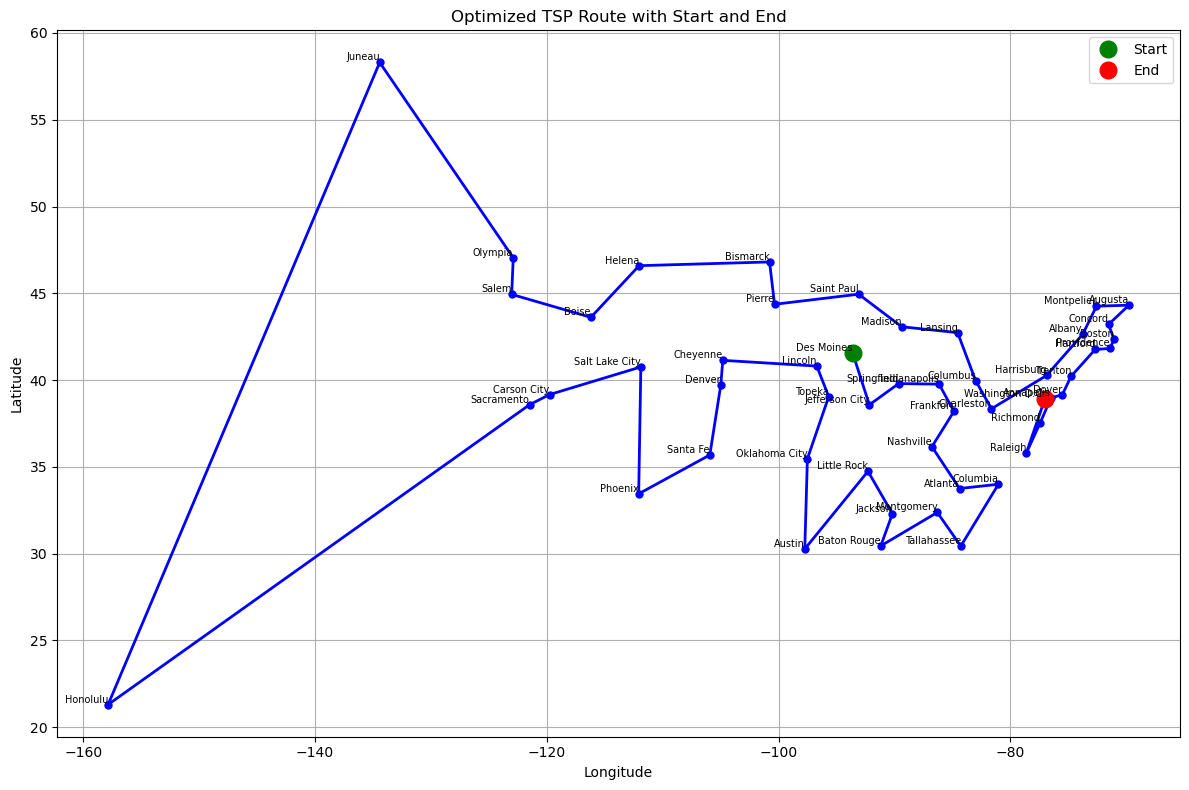

In [102]:
# Get the coordinates of each city in the optimized path
optimized_coords = []
for city in optimized_city_path:
    row = df[df["capital"] == city].iloc[0]
    optimized_coords.append((row["latitude"], row["longitude"]))

# Split into latitude and longitude lists
lats = [coord[0] for coord in optimized_coords]
lons = [coord[1] for coord in optimized_coords]

# Plot the path
plt.figure(figsize=(12, 8))
plt.plot(lons, lats, '-o', color='blue', linewidth=2, markersize=5)

# Annotate city names
for i, city in enumerate(optimized_city_path):
    plt.text(lons[i], lats[i], city, fontsize=7, ha='right', va='bottom')

# Highlight the start point (green) and end point (red)
plt.plot(lons[0], lats[0], 'go', markersize=12, label="Start")
plt.plot(lons[-1], lats[-1], 'ro', markersize=12, label="End")

# Add legend and labels
plt.title("Optimized TSP Route with Start and End")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

In [103]:
# Create map centered on the average coordinates (middle of USA)
map_center = [sum(lats)/len(lats), sum(lons)/len(lons)]
m = folium.Map(location=map_center, zoom_start=5)

# Add start point marker (green)
folium.Marker(
    location=(lats[0], lons[0]),
    popup=f"Start: {optimized_city_path[0]}",
    icon=folium.Icon(color='green', icon='play')
).add_to(m)

# Add end point marker (red)
folium.Marker(
    location=(lats[-1], lons[-1]),
    popup=f"End: {optimized_city_path[-1]}",
    icon=folium.Icon(color='red', icon='stop')
).add_to(m)

# Add all cities as blue numbered markers
for i, (lat, lon, city) in enumerate(zip(lats, lons, optimized_city_path)):
    folium.CircleMarker(
        location=(lat, lon),
        radius=4,
        fill=True,
        fill_opacity=0.8,
        popup=f"{i+1}. {city}",
        color="blue"
    ).add_to(m)

# Draw the TSP path as a blue polyline
path_coords = list(zip(lats, lons))
folium.PolyLine(path_coords, color="blue", weight=3, opacity=0.7).add_to(m)

m.save("TSP_route.html")

In [104]:
m